# Targeted Maximum Likelihood Estimator
As discussed in other tutorials, the targeted maximum likelihood estimator (TMLE) is a doubly robust estimator. In addition to the average causal effect (defined as $E[Y^{a=1}] - E[Y^{a=0}]$), TMLE can additionally be used to estimate the average causal effect of stochastic treatment regimes

## Stochastic treatments
Stochastic treatment plans are interventions where some proportion $p$ are treated for a binary treatment $A$. Therefore, our estimand is 
$$\psi = E[Y^{a*}]$$
where$a*$ is the treatment plan that corresponds to proportion $p$. For a specific example, we may be interested in the incidence of the outcome $Y$ when $p=0.5$.

## TMLE Procedure
The estimation procedure is similar to the standard TMLE with some modifications. Below is a brief outline

1) Initial estimates for $Y$ are predicted from a statistical model under the observed treatment $Q_0$.
$$E[Y|A, L]$$

2) Predicted probabilities of treatment are estimated from a second statistical model predicting the treatment
$$\Pr(A=1|L)$$

3) Using the predicted probabilities from step 2, we calculate the corresponding weight. Note that the numerator of the weight is the probability of treatment *under the new treatment plan*
$$H = \frac{\Pr(A=a*|L)}{\Pr(A=a|L)}$$

4) Calculate the targeted model $Q_1$ through the targeting step. The following weighted logit model is estimated 
$$logit(Y) = logit(Q_0) + \epsilon$$

5) Using $Q_0$ and the estimated $\epsilon$, the incidence under $a*$ is estimated. 
$$Y^{a*} = expit(logit(Q_0) + \epsilon)$$
Since there are many possible occurrences for $a*$, we can evaluate the above quantity through a Monte-Carlo integration procedure. Briefly, a large number of possible of allotments of $a*$ under $p$ are generated. Each of these is evaluated using the above procedure. The final quantity is the average of these various plans

## An example
To motivate our example, we will use a simulated data set included with *zEpid*. In the data set, we have a cohort of HIV-positive individuals. We are interested in the average treatment effect of antiretroviral therapy (ART) on all-cause mortality at 45-weeks. Based on substantive background knowledge, we believe that the treated and untreated population are exchangeable based gender, age, CD4 T-cell count, and detectable viral load. More specifically, we are interested in the following treatment plans $p = \{0.4, 0.45, 0.5, 0.55, 0.6\}$

We will focus on a complete case analysis since `StochasticTMLE` does not currently support censored data. Therefore, we will drop all the missing data on the outcome (`dead`). This will leave 517 observations with no missing data

In [1]:
from zepid import load_sample_data, spline
from zepid.causal.doublyrobust import StochasticTMLE

import matplotlib.pyplot as plt
%matplotlib inline

df = load_sample_data(False)
df[['age_rs1', 'age_rs2']] = spline(df, 'age0', n_knots=3, term=2, restricted=True)
df[['cd4_rs1', 'cd4_rs2']] = spline(df, 'cd40', n_knots=3, term=2, restricted=True)

df = df.drop(columns=['cd4_wk45']).dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517 entries, 0 to 546
Data columns (total 12 columns):
id         517 non-null int64
male       517 non-null int64
age0       517 non-null int64
cd40       517 non-null int64
dvl0       517 non-null int64
art        517 non-null int64
dead       517 non-null float64
t          517 non-null float64
age_rs1    517 non-null float64
age_rs2    517 non-null float64
cd4_rs1    517 non-null float64
cd4_rs2    517 non-null float64
dtypes: float64(6), int64(6)
memory usage: 52.5 KB


Our data is now ready to conduct a complete case analysis using TMLE. First, we initialize `StochasticTMLE` with our complete-case data (`df`), the treatment (`art`), and the outcome (`dead`). We will also specify the optional argument `verbose=True` so all intermediate parametric models are printed to the console.

In [2]:
stmle = StochasticTMLE(df, exposure='art', outcome='dead', verbose=True)

### Treatment Model
As the first step, we will estimate the treatment model. We believe the sufficient set for the treatment model is gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). To relax the functional for assumptions, we will model age and CD4 using restricted quadratic splines

In [3]:
stmle.exposure_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')


----------------------------------------------------------------
MODEL: art ~ male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0
-----------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    art   No. Observations:                  517
Model:                            GLM   Df Residuals:                      508
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -206.06
Date:                Thu, 09 Jan 2020   Deviance:                       412.12
Time:                        16:38:07   Pearson chi2:                     510.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]

### Outcome Model
Now, we will estimate the outcome model. We will model the outcomes as ART (`art`), gender (`male`), age (`age0`), CD4 T-cell (`cd40`) and detectable viral load (`dvl0`). Again, we will model age and CD4 using restricted quadratic splines

In [4]:
stmle.outcome_model('male + age0 + age_rs1 + age_rs2 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')

Q-model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                  517
Model:                            GLM   Df Residuals:                      508
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -204.76
Date:                Thu, 09 Jan 2020   Deviance:                       409.52
Time:                        16:38:07   Pearson chi2:                     511.
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2878      2.700     -1.588      0.112      -9.581       1.005
male          -0.1008      0.330     -0.306 

### Targeting Step
In the final step; targeting, Monte-Carlo integration, and estimation are all completed. This is done through the `fit()` function. In this function, we specify the percent to be treated in the population (0.4 in this example). 

In [5]:
stmle.fit(p=0.4, samples=500)

Targeting Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   dead   No. Observations:                  517
Model:                            GLM   Df Residuals:                      513
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -189.56
Date:                Thu, 09 Jan 2020   Deviance:                       379.12
Time:                        16:38:07   Pearson chi2:                     521.
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1903      0.132     -1.438      0.150      -0.450       0.069


We can view the overall results through the following code.

In [6]:
stmle.summary()

          Stochastic Targeted Maximum Likelihood Estimator            
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Truncated:        0                   
Q-Model:          Logistic        g-model:              Logistic            
No. Resamples:    500            
Overall incidence:       0.146
Marginal 95% CL:         [0.112 0.181]
Conditional 95% CL:      [0.113 0.179]


Our results indicate that had 40% of the cohort been given ART at diagnosis the incidence of all-cause mortality at 45 weeks would have been 14.6% (95% CL: 11.2%, 18.1%). 

### Diagnostics
Diagnostics for the g-model and the Q-model are available through the `run_diagnostics()` function.

                         Diagnostics                                  
                 Natural Course Prediction Accuracy                   
Mean:                    -0.0                
Standard Deviation:      0.349               
Median:                  -0.107              
Minimum value:           -0.696              
Maximum value:           0.974               
----------------------------------------------------------------------
               Inverse Probability Weight Denominator                 
Mean (expected=2):       1.987               
Standard Deviation:      2.342               
Minimum value:           1.06                
Maximum value:           16.897              
----------------------------------------------------------------------
                        Targeting Step                                
Epsilon:                 -0.19               


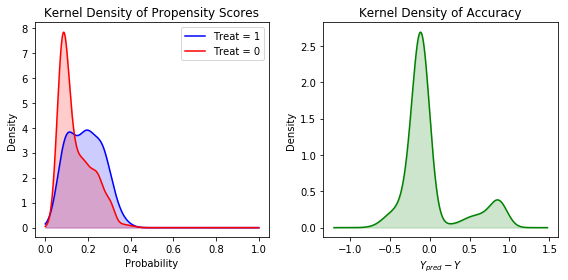

In [7]:
stmle.run_diagnostics()

Both models appear to have adequate performance (there are no obvious problems). Note that these results do not assess the treatment plan of interest, but rather the g-model denominator and the performance of the Q-model for the observed treatment values. It should be noted that the positivity assumption is weakened under the stochastic intervention. 

### Tuning parameters
Luckily in our example, we don't have an issue estimating the predicted probabilities of ART. This can possibly cause issues in the estimation procedure. One solution is to "trim" the estimated propensity scores. This is commonly used in propensity score and IPTW methods. By using the bound optional argument in the `exposure_model()` function, we can restrict the predicted probabilities.

As demonstration, we will restrict to predicted probabilties of treatment between 0.08 to 0.95

In [8]:
stmle = StochasticTMLE(df, exposure='art', outcome='dead', verbose=False)
stmle.exposure_model('male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0', bound=[0.08, 0.95])
stmle.outcome_model('art + male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')
stmle.fit(p=0.4)
stmle.summary()

          Stochastic Targeted Maximum Likelihood Estimator            
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Truncated:        96                  
Q-Model:          Logistic        g-model:              Logistic            
No. Resamples:    100            
Overall incidence:       0.149
Marginal 95% CL:         [0.115 0.184]
Conditional 95% CL:      [0.116 0.182]


When restricting the probabilities in our example, similar results are obtained. Caution should be used when using this argument. This approach may "smooth" over important outliers or change the generalizability/transportability of your results. This should be considered as a last option if you have trouble estimating TMLE with good performance for the IPTW diagnostics.

### A Simple Visualization
Now we will create a simple visualization for all the treatment plans of interest. We do this by writing a `for` loop to cycle through the treatment plans of interest.

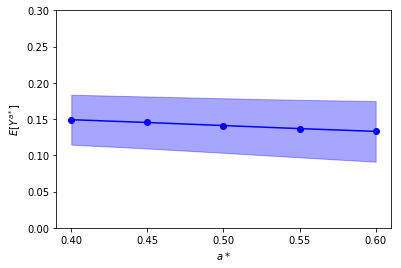

In [9]:
plans = [0.4, 0.45, 0.5, 0.55, 0.6]
est = []
lcl = []
ucl = []

for i in plans:
    stmle = StochasticTMLE(df, exposure='art', outcome='dead', verbose=False)
    stmle.exposure_model('male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')
    stmle.outcome_model('art + male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')
    stmle.fit(p=i)
    est.append(stmle.marginal_outcome)
    lcl.append(stmle.marginal_ci[0])
    ucl.append(stmle.marginal_ci[1])

plt.plot(plans, est, 'o-', c='b')
plt.fill_between(plans, ucl, lcl, alpha=0.35, color='b')
plt.xticks(plans)
plt.xlim(0.39, 0.61)
plt.ylim(0.0, 0.3)
plt.xlabel(r'$a*$')
plt.ylabel(r'$E[Y^{a*}]$')
plt.show()

From this graphic, we can easily visualize how changing `p` results in a change in the incidence of death at 45 weeks. If we wanted, we could extend this to other values or values between those

### Conditional Interventions
The proportion treated `p` can also be conditional on observed variables. As a simple example, we will look at `p` conditional on gender.

In [10]:
stmle = StochasticTMLE(df, exposure='art', outcome='dead')
stmle.exposure_model('male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')
stmle.outcome_model('art + male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0')
stmle.fit(p=[0.2, 0.7], conditional=["df['male']==1", "df['male']==0"])
stmle.summary()

          Stochastic Targeted Maximum Likelihood Estimator            
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Truncated:        0                   
Q-Model:          Logistic        g-model:              Logistic            
No. Resamples:    100            
Overall incidence:       0.13
Marginal 95% CL:         [0.088 0.172]
Conditional 95% CL:      [0.089 0.171]


### Machine Learning
Finally, $Q_0$ and $g$ can instead be estimated through machine learning estimators. For simplicity of the example, I will demonstrate the following with generalized additive models with the *PyGAM* library.

In [11]:
from sklearn.linear_model import LogisticRegression
from pygam import LogisticGAM

# Setting up models
gam = LogisticGAM()
log = LogisticRegression(penalty='l1', random_state=201)

# Estimating Stochastic TMLE
tmle = StochasticTMLE(df, exposure='art', outcome='dead')
tmle.exposure_model('male + age0 + cd40 + cd4_rs1 + cd4_rs2 + dvl0 + male:dvl0', 
                    custom_model=log)
tmle.outcome_model('art + male + age0 + dvl0  + cd40', 
                   custom_model=gam)
tmle.fit(p=0.4, samples=500)
tmle.summary()

c:\users\zivic\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


          Stochastic Targeted Maximum Likelihood Estimator            
Treatment:        art             No. Observations:     517                 
Outcome:          dead            No. Truncated:        0                   
Q-Model:          Logistic        g-model:              Logistic            
No. Resamples:    500            
Overall incidence:       0.163
Marginal 95% CL:         [0.128 0.198]
Conditional 95% CL:      [0.13  0.195]


## Conclusion
In this tutorial, I have described TMLE for stochastic interventions and its usage in *zEpid*. In this tutorial, I have focused on a complete case analysis for a binary outcome with both parametric logistic regression models and machine learning algorithms. `StochasticTMLE` is also compatible with continuous outcomes

### References
Díaz I & van der Laan MJ. (2013). "Assessing the causal effect of policies: an example using stochastic interventions." The International Journal of Biostatistics, 9(2), 161-174.